# Callback Analysis

In [1]:
import sys
sys.path.append("..")

import os
import seaborn as sns
from google.cloud import bigquery
from src import Flow
from matplotlib import pyplot as plt




credential_path = "/home/kerri/bigquery-jaya-consultant-cosmic-octane-88917-c46ba9b53a3b.json"
assert os.path.exists(credential_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
project_id = 'cosmic-octane-88917'
client = bigquery.Client(project=project_id)


In [2]:
sql = """ WITH subset AS (
SELECT *
FROM `cosmic-octane-88917.analytics_us._VW_CallEvent`
WHERE FlowName = '{0}'
AND EXTRACT(DATE FROM TimeStamp) BETWEEN '2020-06-01' AND '2020-12-01'
AND CallingNumber != 'Restricted'
),

callbacks AS (
SELECT DISTINCT CallingNumber,
       CASE WHEN LEFT(CallingNumber, 4) in ('+1800%') THEN True ELSE False END AS TollFreeNumber,
       EXTRACT(DATE FROM c1.TimeStamp) date,
       c1.TimeStamp, 
       c1.SessionId first_session_id, 
       c1.CallAnswerIndicator,
       c1.CallDuration first_call_duration,
       c2.TimeStamp, 
       c2.SessionId second_session_id,
       c2.CallAnswerIndicator,
       c2.CallDuration second_call_duration,
       ABS(TIMESTAMP_DIFF(c1.TimeStamp, c2.TimeStamp, DAY)) day_diff
FROM subset c1
INNER JOIN subset c2
USING(CallingNumber)
WHERE c1.SessionId != c2.SessionId
AND c1.TimeStamp < c2.TimeStamp
)


SELECT date,  
       TollFreeNumber, 
       AVG(day_diff) mean_days_between_calls, 
       STDDEV(day_diff) std_days_between_calls, 
       COUNT(*) count,
       AVG(first_call_duration) mean_first_call_duration,
       STDDEV(first_call_duration) std_first_call_duration,
       AVG(second_call_duration) mean_second_call_duration,
       STDDEV(second_call_duration) std_second_call_duration
FROM callbacks
GROUP BY date, TollFreeNumber
ORDER BY date, TollFreeNumber
"""


In [102]:
sql = """
WITH major_events AS (
SELECT
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'API_EVENT') AS ActionId,
      NULL AS CallingNumber,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_ApiEvent`

UNION ALL

SELECT
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'CALL_EVENT', ':', CallAnswerIndicator) AS ActionId,
      CallingNumber,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_CallEvent`
WHERE ActionId != 'TRANSFER_33'

UNION ALL

SELECT
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', CAST(DtmfInput AS STRING), '-dtmf') ActionId,
      NULL AS CallingNumber,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_DtmfEvent`

UNION ALL

SELECT
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'MSG_EVENT') AS ActionId,
      NULL AS CallingNumber,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_MsgEvent`

UNION ALL

SELECT
      SessionId,
      TimeStamp,
      CONCAT(ActionId, '~~', 'NLP_EVENT') AS ActionId,
      NULL AS CallingNumber,
      CustomerId,
      FlowName
FROM `cosmic-octane-88917.analytics_us._VW_NlpEvent`
),

filtered AS (
SELECT  SessionId,
        TimeStamp,
        ActionId,
        CallingNumber,
        FlowName
FROM major_events
WHERE FlowName in ("United Kingdom - Customer Service")

),

callback_subset AS (
SELECT DISTINCT *,
        CASE WHEN LEFT(CallingNumber, 4) in ('+1800%') THEN 'Toll Free' ELSE 'Non Toll Free' END AS TollFreeNumber,
        RANK() OVER(PARTITION BY CallingNumber ORDER BY TimeStamp) rank,
        TIMESTAMP_DIFF(TimeStamp, LAG(TimeStamp) OVER(PARTITION BY CallingNumber ORDER BY TimeStamp), DAY) days_since_last_call,
        LAG(session_duration) OVER(PARTITION BY CallingNumber ORDER BY TimeStamp) previous_duration
FROM (
        SELECT DISTINCT 
                CallingNumber, 
                SessionId, 
                MIN(Timestamp) TimeStamp,
                TIMESTAMP_DIFF(MAX(TimeStamp), MIN(TimeStamp), SECOND) session_duration,
        
        FROM filtered f
        WHERE CallingNumber != 'Restricted'
        AND CallingNumber IS NOT NULL
        GROUP BY CallingNumber, SessionId
     )
),


metric_prep AS (
SELECT
       SessionId,
       ActionId,
       TimeStamp,
       ROW_NUMBER() OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS rank_event,
       FIRST_VALUE(TimeStamp) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS first_timestamp,
       LEAD(TimeStamp) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS next_timestamp,
       LEAD(ActionId) OVER (PARTITION BY SessionId ORDER BY TimeStamp) AS next_event,
       FlowName,

FROM
filtered
),


Session_paths AS (
SELECT DISTINCT SessionId, TimeStamp, Path
FROM (
    SELECT
      SessionId,
      --FlowName,
      FIRST_VALUE(TimeStamp) OVER(PARTITION BY SessionId ORDER BY TimeStamp) AS TimeStamp,
      STRING_AGG(ActionId, ';') OVER(PARTITION BY SessionId ORDER BY TimeStamp) AS Path,
      RANK() OVER(PARTITION BY SessionId ORDER BY TimeStamp DESC) AS rank
    FROM
        filtered
       )
WHERE rank = 1
),

path_ranks AS (
SELECT *,
      CONCAT(ROW_NUMBER() OVER(), '-Path_Freq_Rank') AS nickname
FROM (
      SELECT
        Path,
        COUNT(TimeStamp) count
      FROM Session_paths
      GROUP BY Path
      ORDER BY count DESC
      )
)


SELECT
       DISTINCT
       m.SessionId AS user_id,
       m.ActionId  AS event_name,
       m.TimeStamp AS time_event,
       CAST(EXTRACT(DATE FROM m.TimeStamp) AS DATETIME) AS date,
       m.rank_event AS rank_event,
       m.next_event AS next_event,
       m.FlowName AS FlowName,
       TIMESTAMP_DIFF(m.TimeStamp, m.first_timestamp, SECOND) AS time_from_start,
       TIMESTAMP_DIFF(m.next_timestamp, m.TimeStamp, SECOND) AS time_to_next,
       pr.nickname AS path_nickname,
       1 AS count,
       cb.CallingNumber,
       cb.rank callback_instance,
       cb.days_since_last_call,
       cb.session_duration,
       cb.previous_duration,
       cb.TollFreeNumber AS TollFreeNumber
FROM metric_prep m
INNER JOIN Session_paths s USING(SessionId)
INNER JOIN path_ranks pr USING(Path)
LEFT JOIN callback_subset cb USING(SessionId)
ORDER BY user_id, time_event 
"""

In [33]:
def plot_callbacks(df):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
    sns.lineplot(data=df, x='date', y='count', hue='TollFreeNumber', ax=axs[0][0]).set(title='Count vs Date')
    sns.lineplot(data=df, x='date', y='days_since_last_call', hue='TollFreeNumber', ax=axs[0][1]).set(title='Average Days Between Calls vs Date')
    sns.lineplot(data=df, x='date', y='previous_duration', hue='TollFreeNumber', ax=axs[1][0]).set(title='Average Duration of First Call vs Date')
    sns.lineplot(data=df, x='date', y='duration', hue='TollFreeNumber', ax=axs[1][1]).set(title='Average Duration of Second Call vs Date')

In [103]:
df = client.query(sql.format("United Kingdom - Customer Service")).to_dataframe()
#plot_callbacks(df)

In [62]:
import pandas as pd
df = pd.DataFrame({'session_duration': [1,2,3,4,5,6,7,8,9,10], 'date': ['z']*10, 'TollFreeNumber': [False, False, False, True, True, True, False, False, False, False]})

df.sort_values(by='date', inplace=True)
grpd = df.groupby(['date', 'TollFreeNumber'])
#using center=false to assign values on window's last row
df['val_rolling_7_mean'] = grpd['session_duration'].transform(lambda x: x.rolling(3, center=False).sum())
df

,session_duration,date,TollFreeNumber,val_rolling_7_mean
0,1,z,False,NaN
1,2,z,False,NaN
2,3,z,False,6.0
3,4,z,True,NaN
4,5,z,True,NaN
5,6,z,True,15.0
6,7,z,False,12.0
7,8,z,False,18.0
8,9,z,False,24.0
9,10,z,False,27.0


In [97]:
data = df.copy()

In [75]:
df = data.copy()

WHERE FlowName in {0}
AND EXTRACT(DATE FROM TimeStamp) BETWEEN '{1}' AND '{2}'

In [104]:
path_metrics = df.groupby(['date', 'TollFreeNumber']).agg({'session_duration': ['mean'],
                                         'previous_duration': ['mean'],
                                          'days_since_last_call': ['mean'],
                                         'count': ['sum']},
                                                         as_index=False).reset_index()
df = pd.DataFrame({'TollFreeNumber': path_metrics['TollFreeNumber'],
                   'date': path_metrics['date'],
                   'avg_duration': path_metrics['session_duration']['mean'],
                   'avg_previous_duration': path_metrics['previous_duration']['mean'],
                   'avg_days_since_last_call': path_metrics['days_since_last_call']['mean'],
                   'count': path_metrics['count']['sum']})

df.sort_values(by='date', inplace=True)
grpd = df.groupby(['TollFreeNumber'])


df['avg_14_day_avg_duration'] = grpd['avg_duration'].transform(lambda x: x.rolling(3, center=False).mean())
df['avg_14_day_avg_previous_duration'] = grpd['avg_previous_duration'].transform(lambda x: x.rolling(3, center=False).mean())
df['avg_14_day_count'] = grpd['count'].transform(lambda x: x.rolling(3, center=False).mean())
df

,TollFreeNumber,date,avg_duration,avg_previous_duration,avg_days_since_last_call,count,avg_14_day_avg_duration,avg_14_day_avg_previous_duration,avg_14_day_count
0,Non Toll Free,2020-04-30,0.000000,0.000000,0.000000,91,NaN,NaN,NaN
1,Non Toll Free,2020-05-01,0.000000,0.000000,0.000000,136,NaN,NaN,NaN
2,Non Toll Free,2020-05-02,0.000000,0.000000,0.500000,2,0.000000,0.000000,76.333333
3,Non Toll Free,2020-05-05,0.000000,NaN,NaN,4,0.000000,NaN,47.333333
4,Non Toll Free,2020-05-06,0.000000,0.000000,5.000000,4,0.000000,NaN,3.333333
...,...,...,...,...,...,...,...,...,...
221,Non Toll Free,2020-12-15,0.000925,0.000722,5.205320,43260,0.000974,0.000317,34280.333333
222,Non Toll Free,2020-12-16,0.000802,0.000390,6.167352,37399,0.000695,0.000447,42676.000000
223,Non Toll Free,2020-12-17,0.000673,0.000208,7.077846,32707,0.000800,0.000440,37788.666667
224,Non Toll Free,2020-12-18,0.001160,0.000883,6.585652,31900,0.000878,0.000494,34002.000000


[Text(0.5, 1.0, 'Average Duration of Second Call vs Date')]

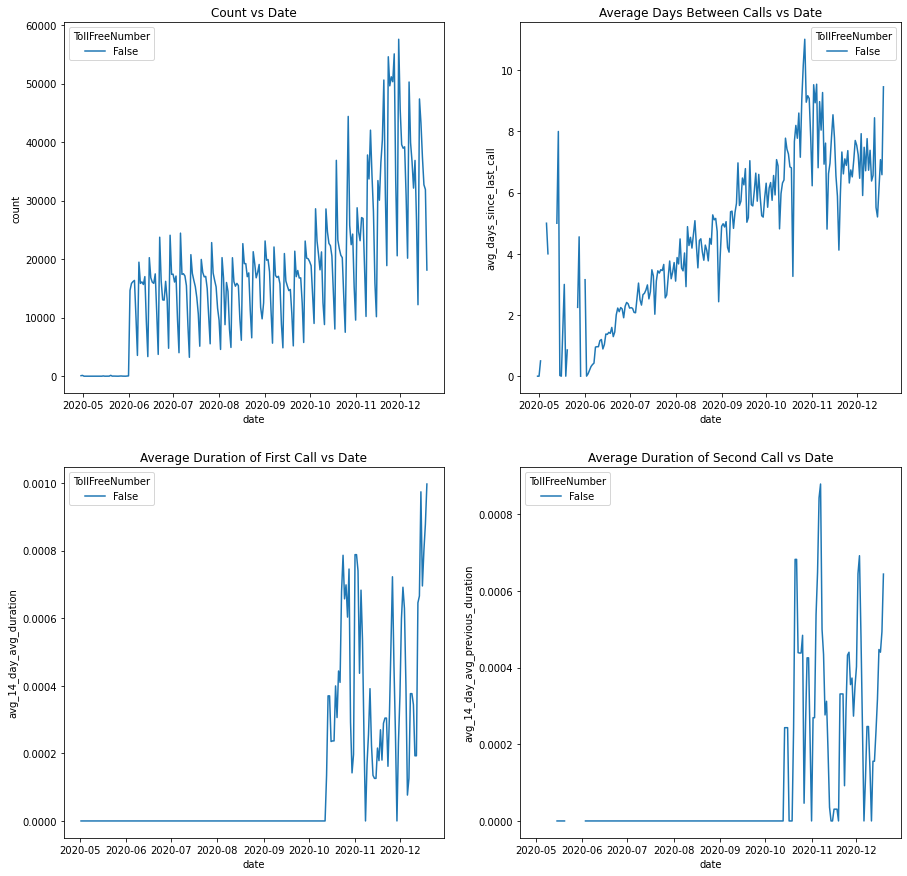

In [99]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
sns.lineplot(data=df, x='date', y='count', hue='TollFreeNumber', ax=axs[0][0]).set(title='Count vs Date')
sns.lineplot(data=df, x='date', y='avg_days_since_last_call', hue='TollFreeNumber', ax=axs[0][1]).set(title='Average Days Between Calls vs Date')
sns.lineplot(data=df, x='date', y='avg_14_day_avg_duration', hue='TollFreeNumber', ax=axs[1][0]).set(title='Average Duration of First Call vs Date')
sns.lineplot(data=df, x='date', y='avg_14_day_avg_previous_duration', hue='TollFreeNumber', ax=axs[1][1]).set(title='Average Duration of Second Call vs Date')

In [100]:
import plotly.graph_objects as go
import plotly.express as px

def plot_traces(fig: go.Figure,
                data: pd.DataFrame,
                x: str,
                y: str,
                hue: str,
                row: int,
                col: int,
                mode: str = 'lines') -> go.Figure:
    """ The goal is create a similar behavior as plotly express or seaborn.
        This function will take x, y, and hue column names and use them to layer
        the correct scatter plots together.

    :param fig: ploty fig where this plot (or these traces) will be places
    :param data: dataframe containing all the columns listed in x, y, and hue
    :param x: column name of x-axis
    :param y: column name of y-axis
    :param hue: column name of category column
    :param row: the row number inside the fig where the plot will be located
    :param col: the column number inside the fig where the plot
    :param mode: plotly.graph_objects.Scatter mode value
    :return: plot fig with plot added s
    """
    for n, category in enumerate(data[hue].unique()):
        temp = data[data[hue] == category]
        chart = go.Scatter(x=temp[x],
                           y=temp[y],
                           mode='lines',
                           name=category,
                           marker_color=px.colors.sequential.Plasma[n]
                           )
        fig.add_trace(chart, row=row, col=col)
    return fig

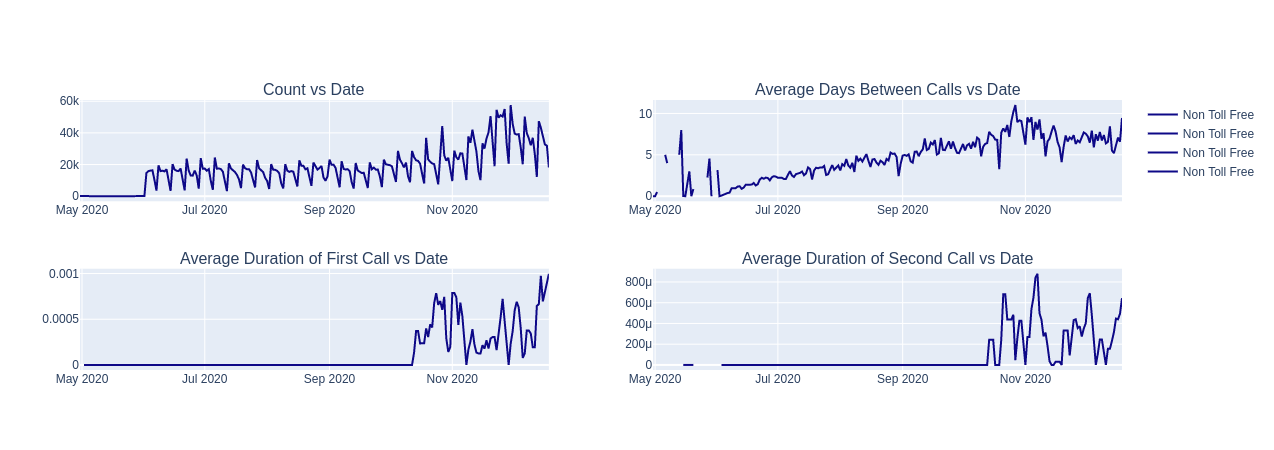

In [105]:
from plotly.subplots import make_subplots

titles = ('Count vs Date', 'Average Days Between Calls vs Date', 'Average Duration of First Call vs Date', 'Average Duration of Second Call vs Date')
fig = make_subplots(rows=2, cols=2, subplot_titles=titles)
fig = plot_traces(fig,
                  data=df,
                  x='date',
                  y='count',
                  hue='TollFreeNumber',
                  row=1, col=1)

fig = plot_traces(fig,
                  data=df,
                  x='date',
                  y='avg_days_since_last_call',
                  hue='TollFreeNumber',
                  row=1, col=2)

fig = plot_traces(fig,
                  data=df,
                  x='date',
                  y='avg_14_day_avg_duration',
                  hue='TollFreeNumber',
                  row=2, col=1)

fig = plot_traces(fig,
                  data=df,
                  x='date',
                  y='avg_14_day_avg_previous_duration',
                  hue='TollFreeNumber',
                  row=2, col=2)

fig.show()

## Callbacks - United Kingdom - Customer Service

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There is a ver pronounced downward trend in the number of days between calls, although this might not be real. It could be an affect of callbacks that haven't occured yet.
- There is a downward trend in the count of callbacks, although this might not be real. It could be an affect of callbacks that haven't occured yet. With that gap in information in mind we could say that the number of callbacks occuring is probably NOT trending upwards.
- The second call started out with a similar avgerage duration in June-July but in the most recent months it's moved up faster than the first call
- The toll free numbers have significantly shorter call durations
- the toll free numbers followed the downward trend of but consistantly have more time between calls 

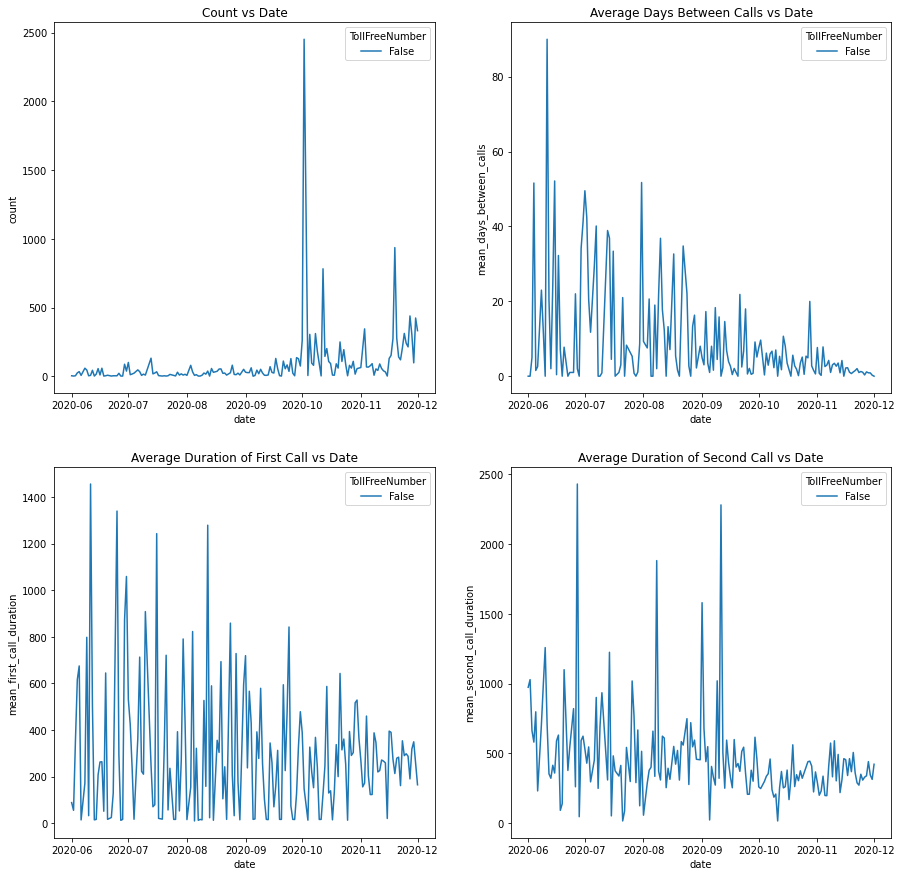

In [5]:
df = client.query(sql.format("Germany - Customer Service")).to_dataframe()
plot_callbacks(df)

## Callbacks - Germany - Customer Service

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There is a slight downward trend in the number of days between calls
- First and Second call duration appear to be independent. Again the call duration appears to be affected by the date.
- There we no toll free numbers

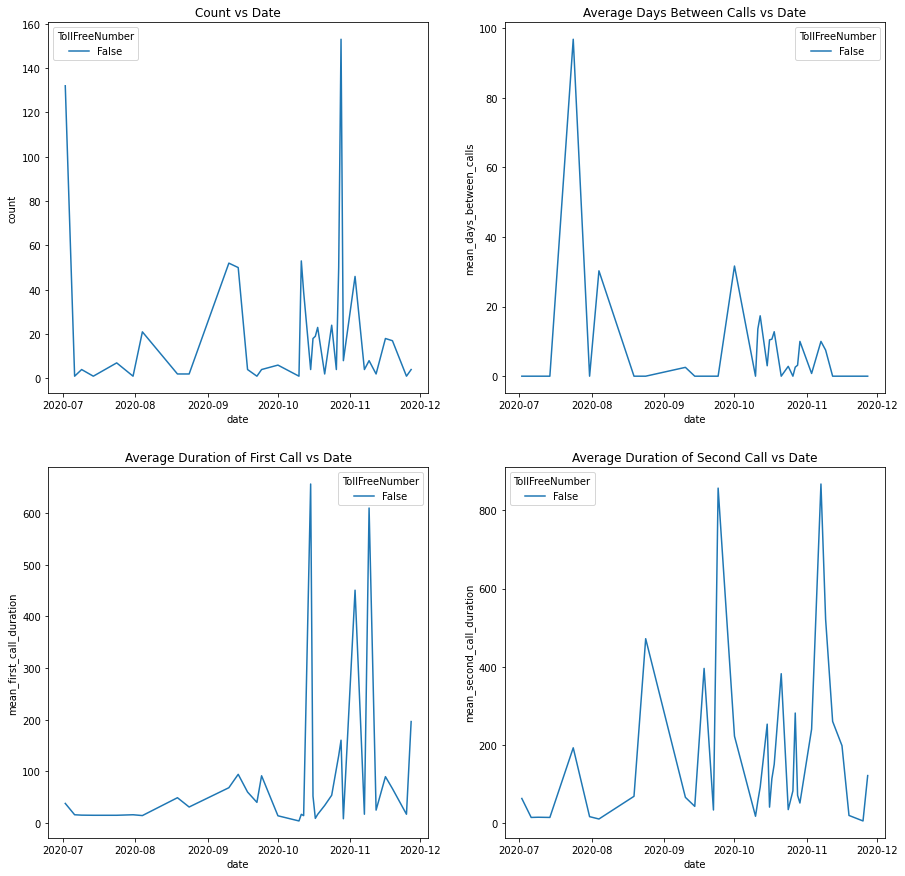

In [6]:
df = client.query(sql.format("Spain - Customer Service")).to_dataframe()
plot_callbacks(df)

## Callbacks - Spain - Customer Service

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- The presence of callbacks is sparce in this dataset
- The first and second call duration seems to be independent of each other but dependent on the date
- This dataset did not have all toll free numbers

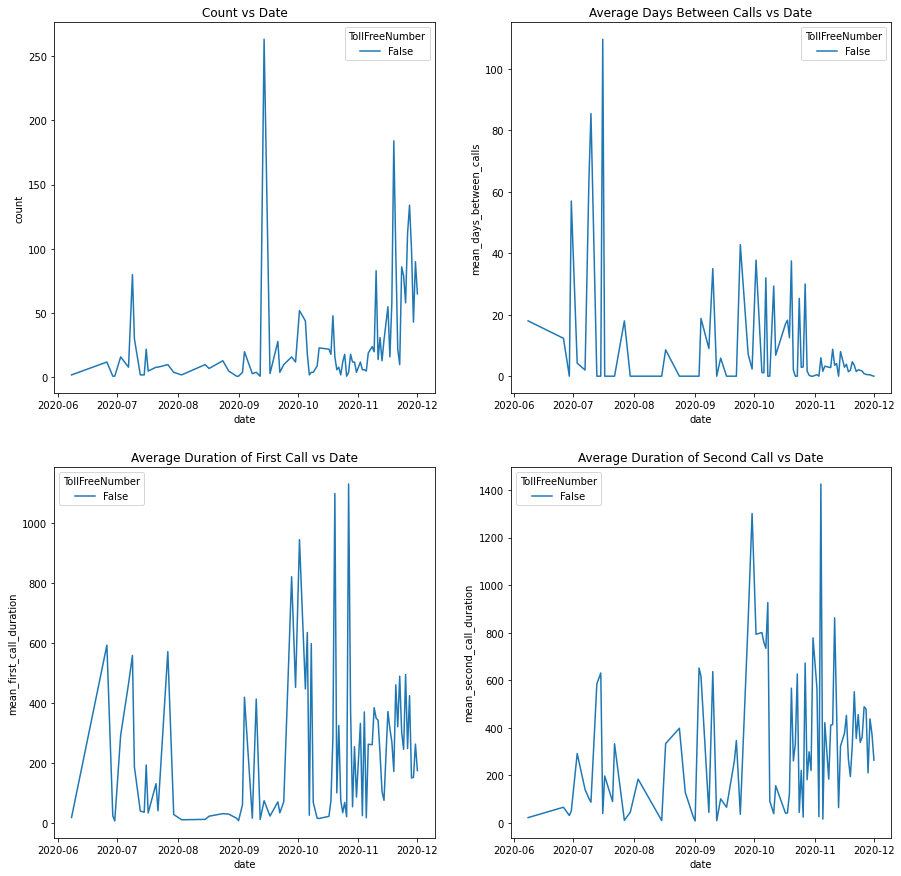

In [7]:
df = client.query(sql.format("France - Customer Service")).to_dataframe()
plot_callbacks(df)

## Callbacks - Spain - Customer Service

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- The presence of callbacks is sparce in this dataset
- The first and second call duration seems to be independent of each other but dependent on the date
- This dataset had only a few toll free numbers that appeared in Sept. 

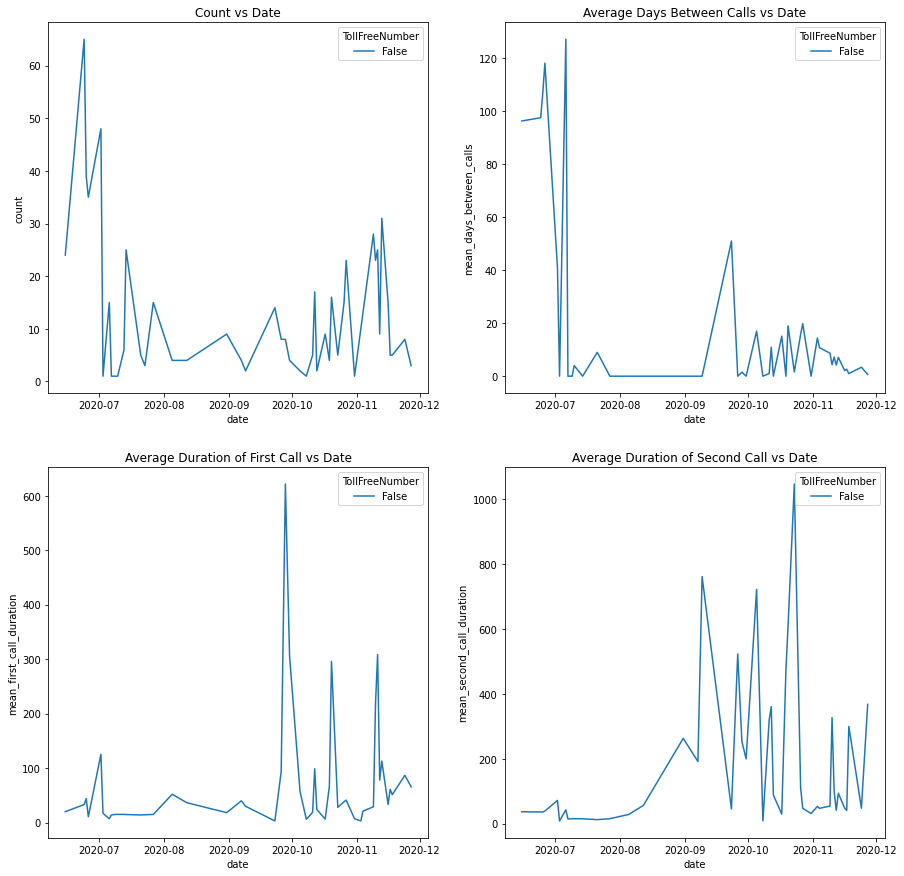

In [8]:
df = client.query(sql.format("Italy - Customer Service")).to_dataframe()
plot_callbacks(df)

## Callbacks - Italy - Customer Service

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- The presence of callbacks in this dataset is spase.
- There appears to be a downward trend in days between calls in the toll free number subgroup. However, given the sparse data it's hard to vaildate that this is true.
- The first and second call duration seems to be independent of each other but dependent on the date

# Solutran

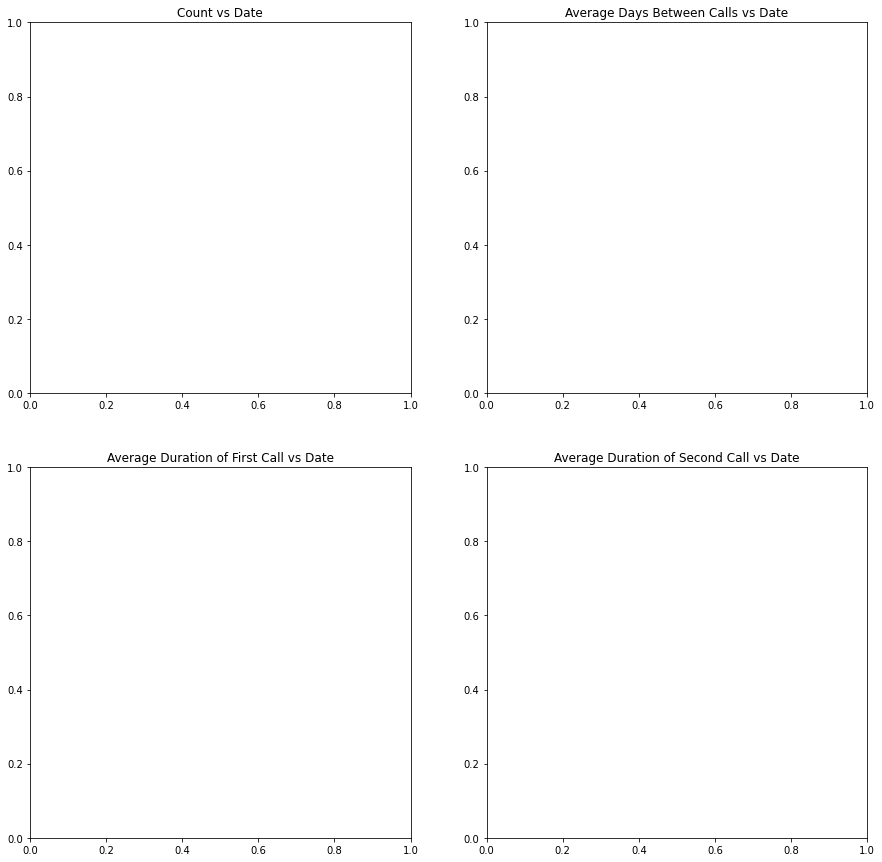

In [9]:
df = client.query(sql.format("HBP MainMenu")).to_dataframe()
plot_callbacks(df)

## Callbacks - HBP MainMenu

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There were not callbacks for this flow

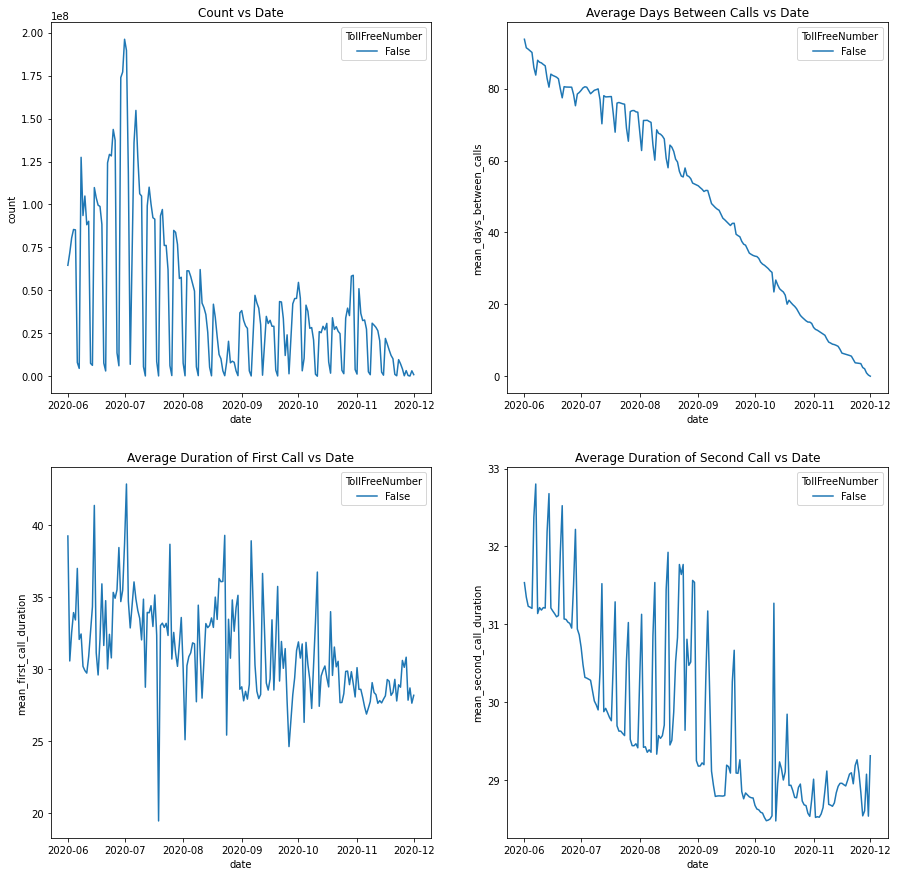

In [10]:
df = client.query(sql.format("Post Call Survey")).to_dataframe()
plot_callbacks(df)

## Callbacks - Post Call Survey

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- Examples of toll free numbers are very sparse
- Both the first and second call durations are very consistant. They show little variation between them.

In [ ]:
df = client.query(sql.format("HBP Order")).to_dataframe()
plot_callbacks(df)

## Callbacks - HBP Order

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- Examples of toll free numbers are very sparse
- The majority of the first call durations are zero indicating that were most likely a transfer that moved the user out of the flow quickly. However, there appears to have been a change in October that has caused the calls to have durations.
- The second calls have had durations since June. However, we see large increase in average call duration around the same time as behavioral change mentioned above. 

In [ ]:
df = client.query(sql.format("HBP Transfer TTEC OffShore")).to_dataframe()
plot_callbacks(df)

## Callbacks - HBP Transfer TTEC OffShore

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- The first call and second call durations are very similar for the non-toll-free numbers
- The second call durations are consistantly longer for the toll free numbers

In [ ]:
df = client.query(sql.format("HBP Transfer Concentrix OffShore")).to_dataframe()
plot_callbacks(df)

## Callbacks - HBP Transfer Concentrix OffShore

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- The first call and second call durations are very similar for the non-toll-free numbers
- Toll free numbers data is very sparse

# American Water

In [ ]:
df = client.query(sql.format("National Flow")).to_dataframe()
plot_callbacks(df)

## Callbacks - National Flow

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- Second call - non-toll-free durations are extremely consistant
- In general the toll free numbers appear to have a longer second call duration than the non-toll-free
- There seems to be an outlier event in mid July, there was a very high count of numbers that called back with in a very short timespan

In [ ]:
df = client.query(sql.format("VA Emergency Outage Message")).to_dataframe()
plot_callbacks(df)

## Callbacks - VA Emergency Outage Message

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There seems to be an outlier event in mid July, there was a very high count of numbers that called back with in a very short timespan

In [ ]:
df = client.query(sql.format("PA Emergency Outage Message")).to_dataframe()
plot_callbacks(df)

## Callbacks - PA Emergency Outage Message

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There seems to be an outlier event in mid July, there was a very high count of numbers that called back with in a very short timespan

In [ ]:
df = client.query(sql.format("IL Emergency Outage Message")).to_dataframe()
plot_callbacks(df)

## Callbacks - PA Emergency Outage Message

The above plot show characteristics of phone numbers that have appeared in more than one SessionId. The top left is the count of how many of these repeat numbers called for the first time on that date. The top right plot shows the number of days between the two sessionIds and the bottom two plots display the duration in minutes for both the first call and the second. 

**TollFreeNumbers** is a subgroup of phone numbers that start with '+1800'

### Takeaways

- There seems to be an outlier event in mid July, there was a very high count of numbers that called back with in a very short timespan